In [1]:
import pandas as pd
import numpy as np
import re
import requests
import datetime
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ambiance

In [2]:
def read_xls(file, sheet):
    
    try:
        df = pd.read_excel(file,sheet)
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [3]:
def read_csv(file):
    
    try:
        df = pd.read_csv(file, sep=' ')
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [4]:
def calculate_bearing(d):
  dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
  ix = int(round(d / (360. / len(dirs))))
    
  return dirs[ix % len(dirs)]

In [5]:
def convert_lat_gps_coord(coor):
    
    lat_deg = coor[:2]
    lat_min = coor[2:4]
    lat_sec = coor[5:7]
    direction = coor[7]
    
    dd = (float(lat_deg) + float(lat_min)/60 + float(lat_sec)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

    return dd

In [6]:
def convert_lon_gps_coord(coor):
    
    lon_deg = coor[1:3]
    lon_min = coor[3:5]
    lon_sec = coor[6:8]
    direction = coor[8]
    
    dd = (float(lon_deg) + float(lon_min)/60 + float(lon_sec)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
    
    return dd

In [7]:
def plot(lat, lng, zoom=10, map_type='roadmap'):
    gmap_options = GMapOptions(lat=lat, lng=lng, 
                               map_type=map_type, zoom=zoom)
    p = gmap(api_key, gmap_options, title='Pays de Gex', 
             width=bokeh_width, height=bokeh_height)
    # definition of the column data source: 
    source = ColumnDataSource(df)
    # see how we specify the x and y columns as strings, 
    # and how to declare as a source the ColumnDataSource:
    center = p.circle('lon', 'lat', size=4, alpha=0.2, 
                      color='yellow', source=source)
    show(p)
    return p

In [8]:
def Alt_toPressure(val):

    return ambiance.Atmosphere(val).pressure[0]

In [9]:
def Alt_toTemp(val):
    
    return ambiance.Atmosphere.T2t(ambiance.Atmosphere(val).temperature)[0]

In [10]:
def Alt_toLayerName(val):
    
    return ambiance.Atmosphere(val).layer_name[0]

In [11]:
def Pressure_toAlt(val):

    return ambiance.Atmosphere.from_pressure(val).h[0]

In [12]:
def Pressure_toTemp(val):
    
    return ambiance.Atmosphere.T2t(ambiance.Atmosphere.from_pressure(val).temperature)[0]

In [13]:
def Clean_Pressure(val):

    # Remove bad data
    if val > 200000:
        return np.nan
    return val

### Read Input Telemetry Spreadsheet

In [14]:
df = read_xls("KB9LNS-13.xlsx","KB9LNS-13")

In [15]:
df.sample(10)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,Num,Column15
48,2023-04-21,11:02:14,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/160209h41...",095TxC,11.70C,2372.68hPa,6.10V,08S,Atlas,5,NaN
57,2023-04-21,11:26:01,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/162557h4...",104TxC,8.70C,641.63hPa,6.01V,05S,Atlas,5,NaN
41,2023-04-21,10:46:04,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/154600h4...",088TxC,8.50C,2313.53hPa,6.06V,07S,Atlas,5,NaN
50,2023-04-21,11:10:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/160956h4...",097TxC,11.30C,79.94hPa,6.04V,04S,Atlas,5,NaN
5,2023-04-21,09:38:59,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143855h40...",054TxC,24.50C,546.95hPa,6.20V,05S,Atlas,5,NaN
56,2023-04-21,11:22:16,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/162212h4...",103TxC,7.40C,421.67hPa,6.09V,06S,Atlas,5,NaN
27,2023-04-21,10:16:03,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/151559h4...",076TxC,7.70C,2297.45hPa,6.12V,07S,Atlas,5,NaN
30,2023-04-21,10:22:24,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/152220h41...",079TxC,6.20C,2244.63hPa,6.17V,07S,Atlas,5,NaN
53,2023-04-21,11:16:04,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/161600h41...",100TxC,8.80C,204.08hPa,6.04V,05S,Atlas,5,NaN
18,2023-04-21,09:56:55,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/145650h41...",067TxC,14.10C,123.32hPa,6.25V,07S,Atlas,5,NaN


In [16]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'TxC', 'Interior Temp ©', 'Pressure',
       'Battery', 'Sat', 'Name', 'Num', 'Column15'],
      dtype='object')

In [17]:
# View large sample of df
df.head(15)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,Num,Column15
0,2023-04-21,09:26:05,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/142600h4...",049TxC,26.30C,956.16hPa,6.19V,05S,Atlas,5,!wVb!
1,2023-04-21,09:30:28,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143023h40...",050TxC,26.70C,802.26hPa,6.20V,06S,Atlas,5,!w4S!
2,2023-04-21,09:31:31,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KD9SAT-10:/143126...",051TxC,25.90C,754.47hPa,6.25V,05S,Atlas,5,!wWv!
3,2023-04-21,09:32:35,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143230h40...",052TxC,25.20C,712.48hPa,6.27V,05S,Atlas,5,NaN
4,2023-04-21,09:36:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/143555h4...",053TxC,25.00C,622.88hPa,6.20V,05S,Atlas,5,NaN
5,2023-04-21,09:38:59,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143855h40...",054TxC,24.50C,546.95hPa,6.20V,05S,Atlas,5,NaN
6,2023-04-21,09:40:03,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,N9XJN-5:/143958h4...",055TxC,23.70C,503.49hPa,6.25V,05S,Atlas,5,NaN
7,2023-04-21,09:41:09,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KD9SAT-10:/144104...",056TxC,22.70C,465.29hPa,6.25V,05S,Atlas,5,NaN
8,2023-04-21,09:42:10,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KC8RFE-3:/144206h...",057TxC,22.00C,435.95hPa,6.27V,05S,Atlas,5,NaN
9,2023-04-21,09:46:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KA3BQE:/144555h40...",058TxC,20.70C,367.51hPa,6.19V,05S,Atlas,5,NaN


### Prepare Telemetry Tracker Data

In [18]:
# Flight telemetry info
df.head(5)

,Date,Time,TZ,Path,TxC,Interior Temp ©,Pressure,Battery,Sat,Name,Num,Column15
0,2023-04-21,09:26:05,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/142600h4...",049TxC,26.30C,956.16hPa,6.19V,05S,Atlas,5,!wVb!
1,2023-04-21,09:30:28,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143023h40...",050TxC,26.70C,802.26hPa,6.20V,06S,Atlas,5,!w4S!
2,2023-04-21,09:31:31,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KD9SAT-10:/143126...",051TxC,25.90C,754.47hPa,6.25V,05S,Atlas,5,!wWv!
3,2023-04-21,09:32:35,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1:/143230h40...",052TxC,25.20C,712.48hPa,6.27V,05S,Atlas,5,NaN
4,2023-04-21,09:36:00,CDT:,"KB9LNS-13>APLIGA,WIDE2-1,qAO,KS9A-10:/143555h4...",053TxC,25.00C,622.88hPa,6.20V,05S,Atlas,5,NaN


In [19]:
# Expand Telemetry data into all fields

# APRS Telemetry field
df['Telemetry'] = df['Path'].str.split(':', expand=True)[1]
df['Path']      = df['Path'].str.split(':', expand=True)[0]

# GPS Time and Location
df['GPS Time']      = df['Telemetry'].str.split('/', expand=True)[1].str.split('h', expand=True)[0]
df['Lat']           = df['Telemetry'].str.split('/', expand=True)[1].str.split('h', expand=True)[1]
df['Lon']           = df['Telemetry'].str.split('/', expand=True)[2].str.split('W', expand=True)[0] + 'W'
df['Bearing']       = df['Telemetry'].str.split('/', expand=True)[2].str.split('W', expand=True)[1]
df['Speed (mph)']   = df['Telemetry'].str.split('/', expand=True)[3].astype(float)
df['Altitude (ft)'] = df['Telemetry'].str.split('/', expand=True)[4].str.split('=', expand=True)[1].astype(float)

In [23]:
# Unit Conversions

# Time
df['Time'] = pd.to_datetime(df['GPS Time'].str[:6],format= '%H%M%S' ).dt.time

# Speed and distance
df['Speed (kph)']  = df['Speed (mph)'].astype(float) * 1.609344
df['Altitude (m)'] = df['Altitude (ft)'].astype(float) * 0.3048

# Tempuratures
df['Interior Temp (F)'] = df['Interior Temp ©'].str.split('C', expand=True)[0].astype(float)*(9/5)+32
#df2['Exterior Temp (F)'] = df2['Exterior Temp ©'].str.split('C', expand=True)[0].astype(float)*(9/5)+32

# Pressure
df['I Pressure'] = df['Pressure'].str[:4].astype(float)
df['I Pressure'] = pd.Series(df['I Pressure']*100).apply(Clean_Pressure).ffill()
#df2['E Pressure'] = df2['Exterior Pressure'].str[:4].astype(float)

In [24]:
# Compute new telemetry data fields

# Ascent Rate (ft)
df['Altitude Delta (ft)'] = df['Altitude (ft)'].diff()
df['Time Delta (s)'] = pd.to_timedelta(df['Time'].astype(str)).diff(-1).dt.total_seconds().abs()
df['Rate (fps)'] = df['Altitude Delta (ft)'].astype(float) / df['Time Delta (s)'].astype(float)

# Ascent Rate (m)
df['Altitude Delta (m)'] = df['Altitude (m)'].diff()
df['Rate (mps)'] = df['Altitude Delta (m)'].astype(float) / df['Time Delta (s)'].astype(float)

# Direction
df['Cardinal Direction'] = df['Bearing'].str[1:].astype(float).apply(calculate_bearing)

# Time
df['GPS Epoch'] = pd.to_timedelta(df['Time'].astype(str)).dt.total_seconds().astype(int)
epoch=df['GPS Epoch'].iloc[0]
df['GPS Epoch'] = df['GPS Epoch'] - epoch

#### Atmospheric Predictions

In [26]:
# Atmospheric predictions using ISA reference data

# Altitude based predictions
df['Predict Alt Pressure'] = df['Altitude (m)'].apply(Alt_toPressure)
df['Predict Alt Temp(C)'] = df['Altitude (m)'].apply(Alt_toTemp)
df['Predict Alt Temp(F)'] = df['Predict Alt Temp(C)'].astype(float)*(9/5)+32

# Pressure based predictions
df['Predict IP Alt(m)'] = pd.Series(df['I Pressure']).apply(Pressure_toAlt)
df['Predict IP Alt(ft)'] = pd.Series(df['I Pressure']).apply(Pressure_toAlt) * 3.2808399
df['Predict IP Temp(C)'] = pd.Series(df['I Pressure']).apply(Pressure_toTemp)
df['Predict IP Temp(F)'] = df['Predict IP Temp(C)']*(9/5)+32

# Pressure based predictions
#df2['Predict EP Alt(m)'] = pd.Series(df2['E Pressure']*100).apply(Pressure_toAlt)
#df2['Predict EP Alt(ft)'] = df2['Predict EP Alt(m)'] * 3.2808399
#df2['Predict EP Temp(C)'] = pd.Series(df2['E Pressure']*100).apply(Pressure_toTemp)
#df2['Predict EP Temp(F)'] = df2['Predict EP Temp(C)']*(9/5)+32

In [28]:
df.iloc[30]

Date                                            2023-04-21 00:00:00
Time                                                       15:22:20
TZ                                                             CDT:
Path                            KB9LNS-13>APLIGA,WIDE2-1,qAR,KX9A-1
TxC                                                          079TxC
Interior Temp ©                                               6.20C
Pressure                                                 2244.63hPa
Battery                                                       6.17V
Sat                                                             07S
Name                                                          Atlas
Num                                                               5
Column15                                                        NaN
Telemetry               /152220h4113.69N/08811.63WO081/014/A=065636
GPS Time                                                     152220
Lat                                             

In [31]:
# Convert pressure from Pa to hPa
df['I Pressure'] = df['I Pressure']/100
df['Predict Alt Pressure'] = df['Predict Alt Pressure']/100

### Read International Standard Atmosphere Tables

In [32]:
isa = read_csv("International Standard Atmosphere Table.txt")

In [33]:
isa.head(10)

,(ft),(m),𝜽,(K),(◦C),𝜹,(N/m2),(lb/ft2),𝝈,(kg/m3),(slug/ft3),(m/s),(ft/s),(kt)
0,−2000,−609.6,1.0138,292.11,18.96,1.0744,108866,2273.7,1.0598,1.2983,0.002519,342.6,1124.0,666.0
1,−1800,−548.6,1.0124,291.72,18.57,1.0668,108092,2257.5,1.0537,1.2908,0.002505,342.4,1123.0,665.6
2,−1600,−487.7,1.0110,291.32,18.17,1.0592,107322,2241.5,1.0477,1.2834,0.002490,342.2,1123.0,665.1
3,−1400,−426.7,1.0096,290.92,17.77,1.0516,106557,2225.5,1.0416,1.2760,0.002476,341.9,1122.0,664.7
4,−1200,−365.8,1.0083,290.53,17.38,1.0441,105797,2209.6,1.0356,1.2686,0.002461,341.7,1121.0,664.2
5,−1000,−304.8,1.0069,290.13,16.98,1.0367,105041,2193.8,1.0296,1.2612,0.002447,341.5,1120.0,663.7
6,−800,−243.8,1.0055,289.73,16.58,1.0293,104289,2178.1,1.0236,1.2539,0.002433,341.2,1120.0,663.3
7,−600,−182.9,1.0041,289.34,16.19,1.0219,103541,2162.5,1.0177,1.2467,0.002419,341.0,1119.0,662.8
8,−400,−121.9,1.0028,288.94,15.79,1.0145,102798,2147.0,1.0118,1.2394,0.002405,340.8,1118.0,662.4
9,−200,−61.0,1.0014,288.55,15.40,1.0072,102059,2131.6,1.0059,1.2322,0.002391,340.5,1117.0,661.9


In [34]:
isa['hpa'] = isa['(N/m2)']/100

In [35]:
isa['(F)'] = (isa['(◦C)'].str.strip(' ').str.replace('−','-').astype(float)*(9/5))+32

In [36]:
isa.sample(5)

,(ft),(m),𝜽,(K),(◦C),𝜹,(N/m2),(lb/ft2),𝝈,(kg/m3),(slug/ft3),(m/s),(ft/s),(kt),hpa,(F)
238,45600,13898.9,0.7519,216.65,−56.50,0.1414,14328,299.3,0.1881,0.2304,0.000447,295.1,968.1,573.6,143.28,-69.700
129,23800,7254.2,0.8364,241.00,−32.15,0.3909,39612,827.3,0.4674,0.5726,0.001111,311.2,1021.0,604.9,396.12,-25.870
251,48200,14691.4,0.7519,216.65,−56.50,0.1248,12645,264.1,0.1660,0.2033,0.000394,295.1,968.1,573.6,126.45,-69.700
35,5000,1524.0,0.9656,278.24,5.09,0.8320,84307,1760.8,0.8617,1.0555,0.002048,334.4,1097.0,650.0,843.07,41.162
64,10800,3291.8,0.9257,266.75,−6.40,0.6666,67545,1410.7,0.7201,0.8821,0.001712,327.4,1074.0,636.4,675.45,20.480


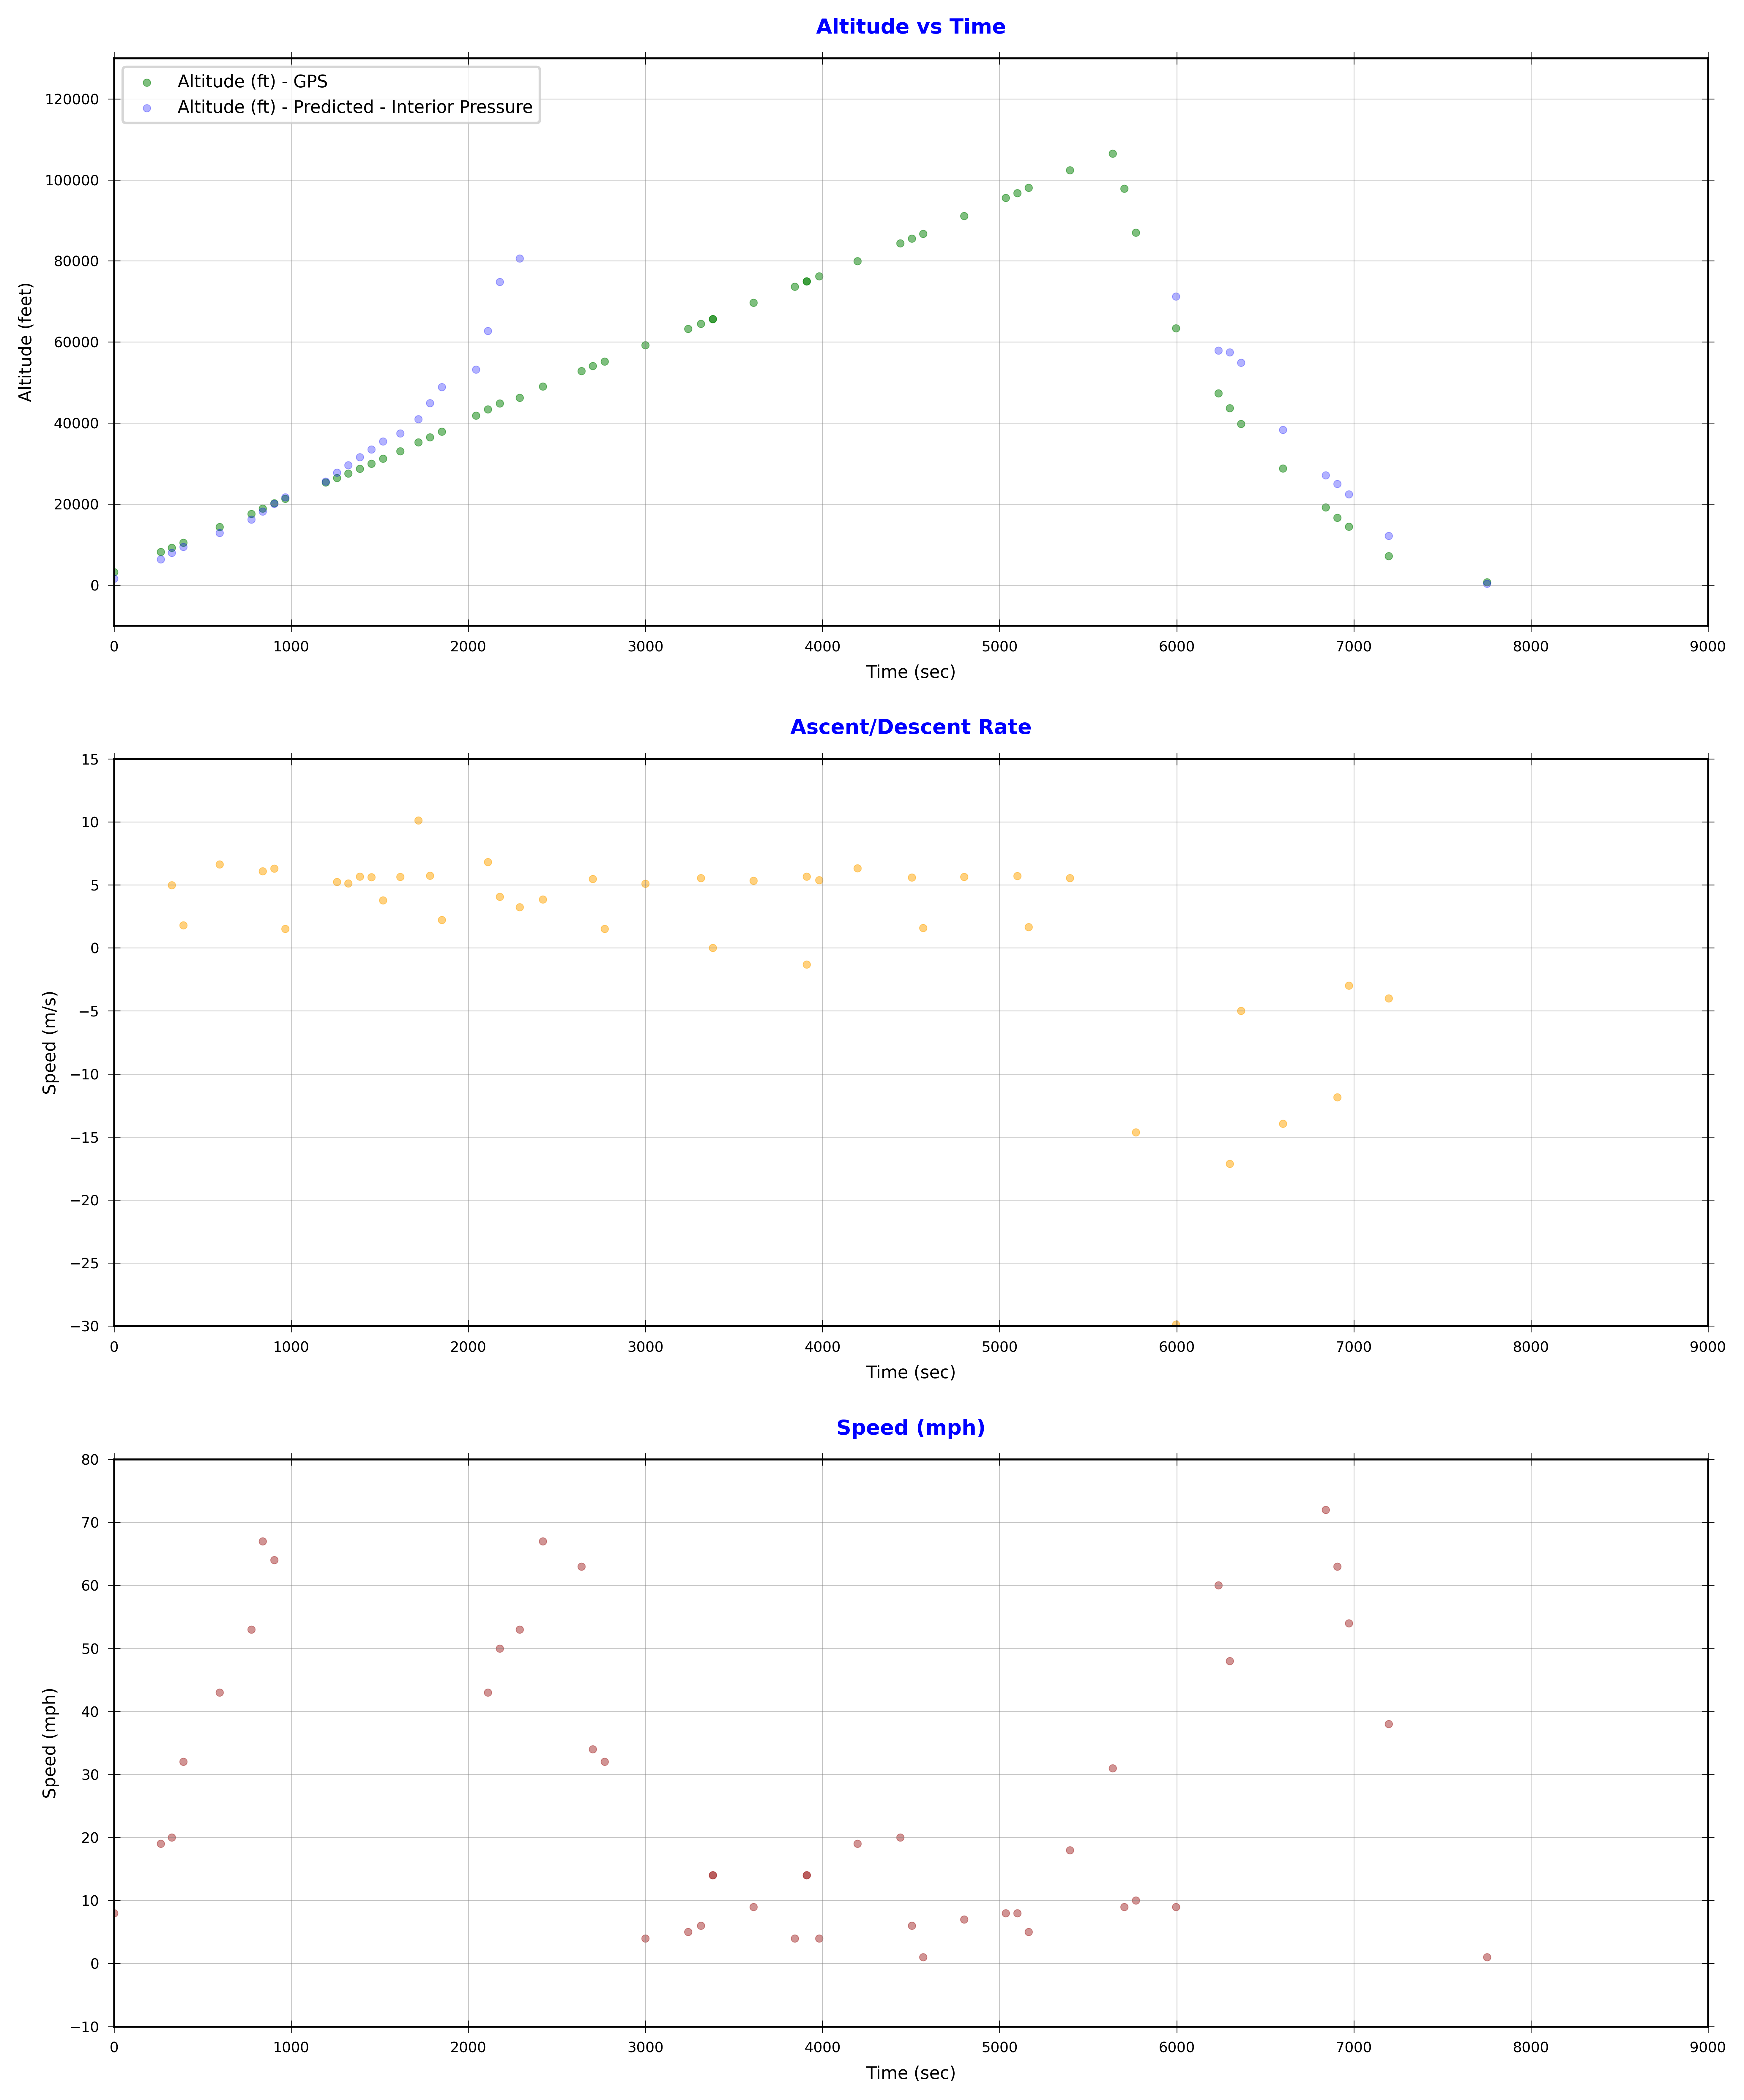

In [37]:
%matplotlib inline

plt.figure(dpi=600, figsize=(10,12))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('GPS Epoch', 'Altitude (ft)', data=df, marker='.', color='green', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot1.scatter('GPS Epoch', 'Predict IP Alt(ft)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.3, linewidth=0.3)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Time (sec)', size='x-small')
plot1.set_ylabel('Altitude (feet)', size='x-small')
plot1.set_title('Altitude vs Time', color='blue', size='small', pad=10.0, weight='bold')
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.set_ylim([-10000,130000])
plot1.set_xlim([0,9000])
plot1.legend(['Altitude (ft) - GPS', 'Altitude (ft) - Predicted - Interior Pressure'], fontsize='x-small', loc='upper left')

plot2.scatter('GPS Epoch', 'Rate (mps)', data=df, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.5,linewidth=0.3)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Time (sec)', size='x-small')
plot2.set_ylabel('Speed (m/s)', size='x-small')
plot2.set_title('Ascent/Descent Rate', color='blue', size='small', pad=10.0, weight='bold')
plot2.grid(visible=True, which='both', linewidth=0.3)
plot2.set_ylim([-30,15])
plot2.set_xlim([0,9000])

plot3.scatter('GPS Epoch', 'Speed (mph)', data=df, marker='.', color='brown', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Time (sec)', size='x-small')
plot3.set_ylabel('Speed (mph)', size='x-small')
plot3.set_title('Speed (mph)', color='blue', size='small', pad=10.0, weight='bold')
plot3.grid(visible=True, which='both', linewidth=0.3)
plot3.set_ylim([-10,80])
plot3.set_xlim([0,9000])

plt.tight_layout(pad=1.5)
plt.show()

ValueError: x and y must be the same size

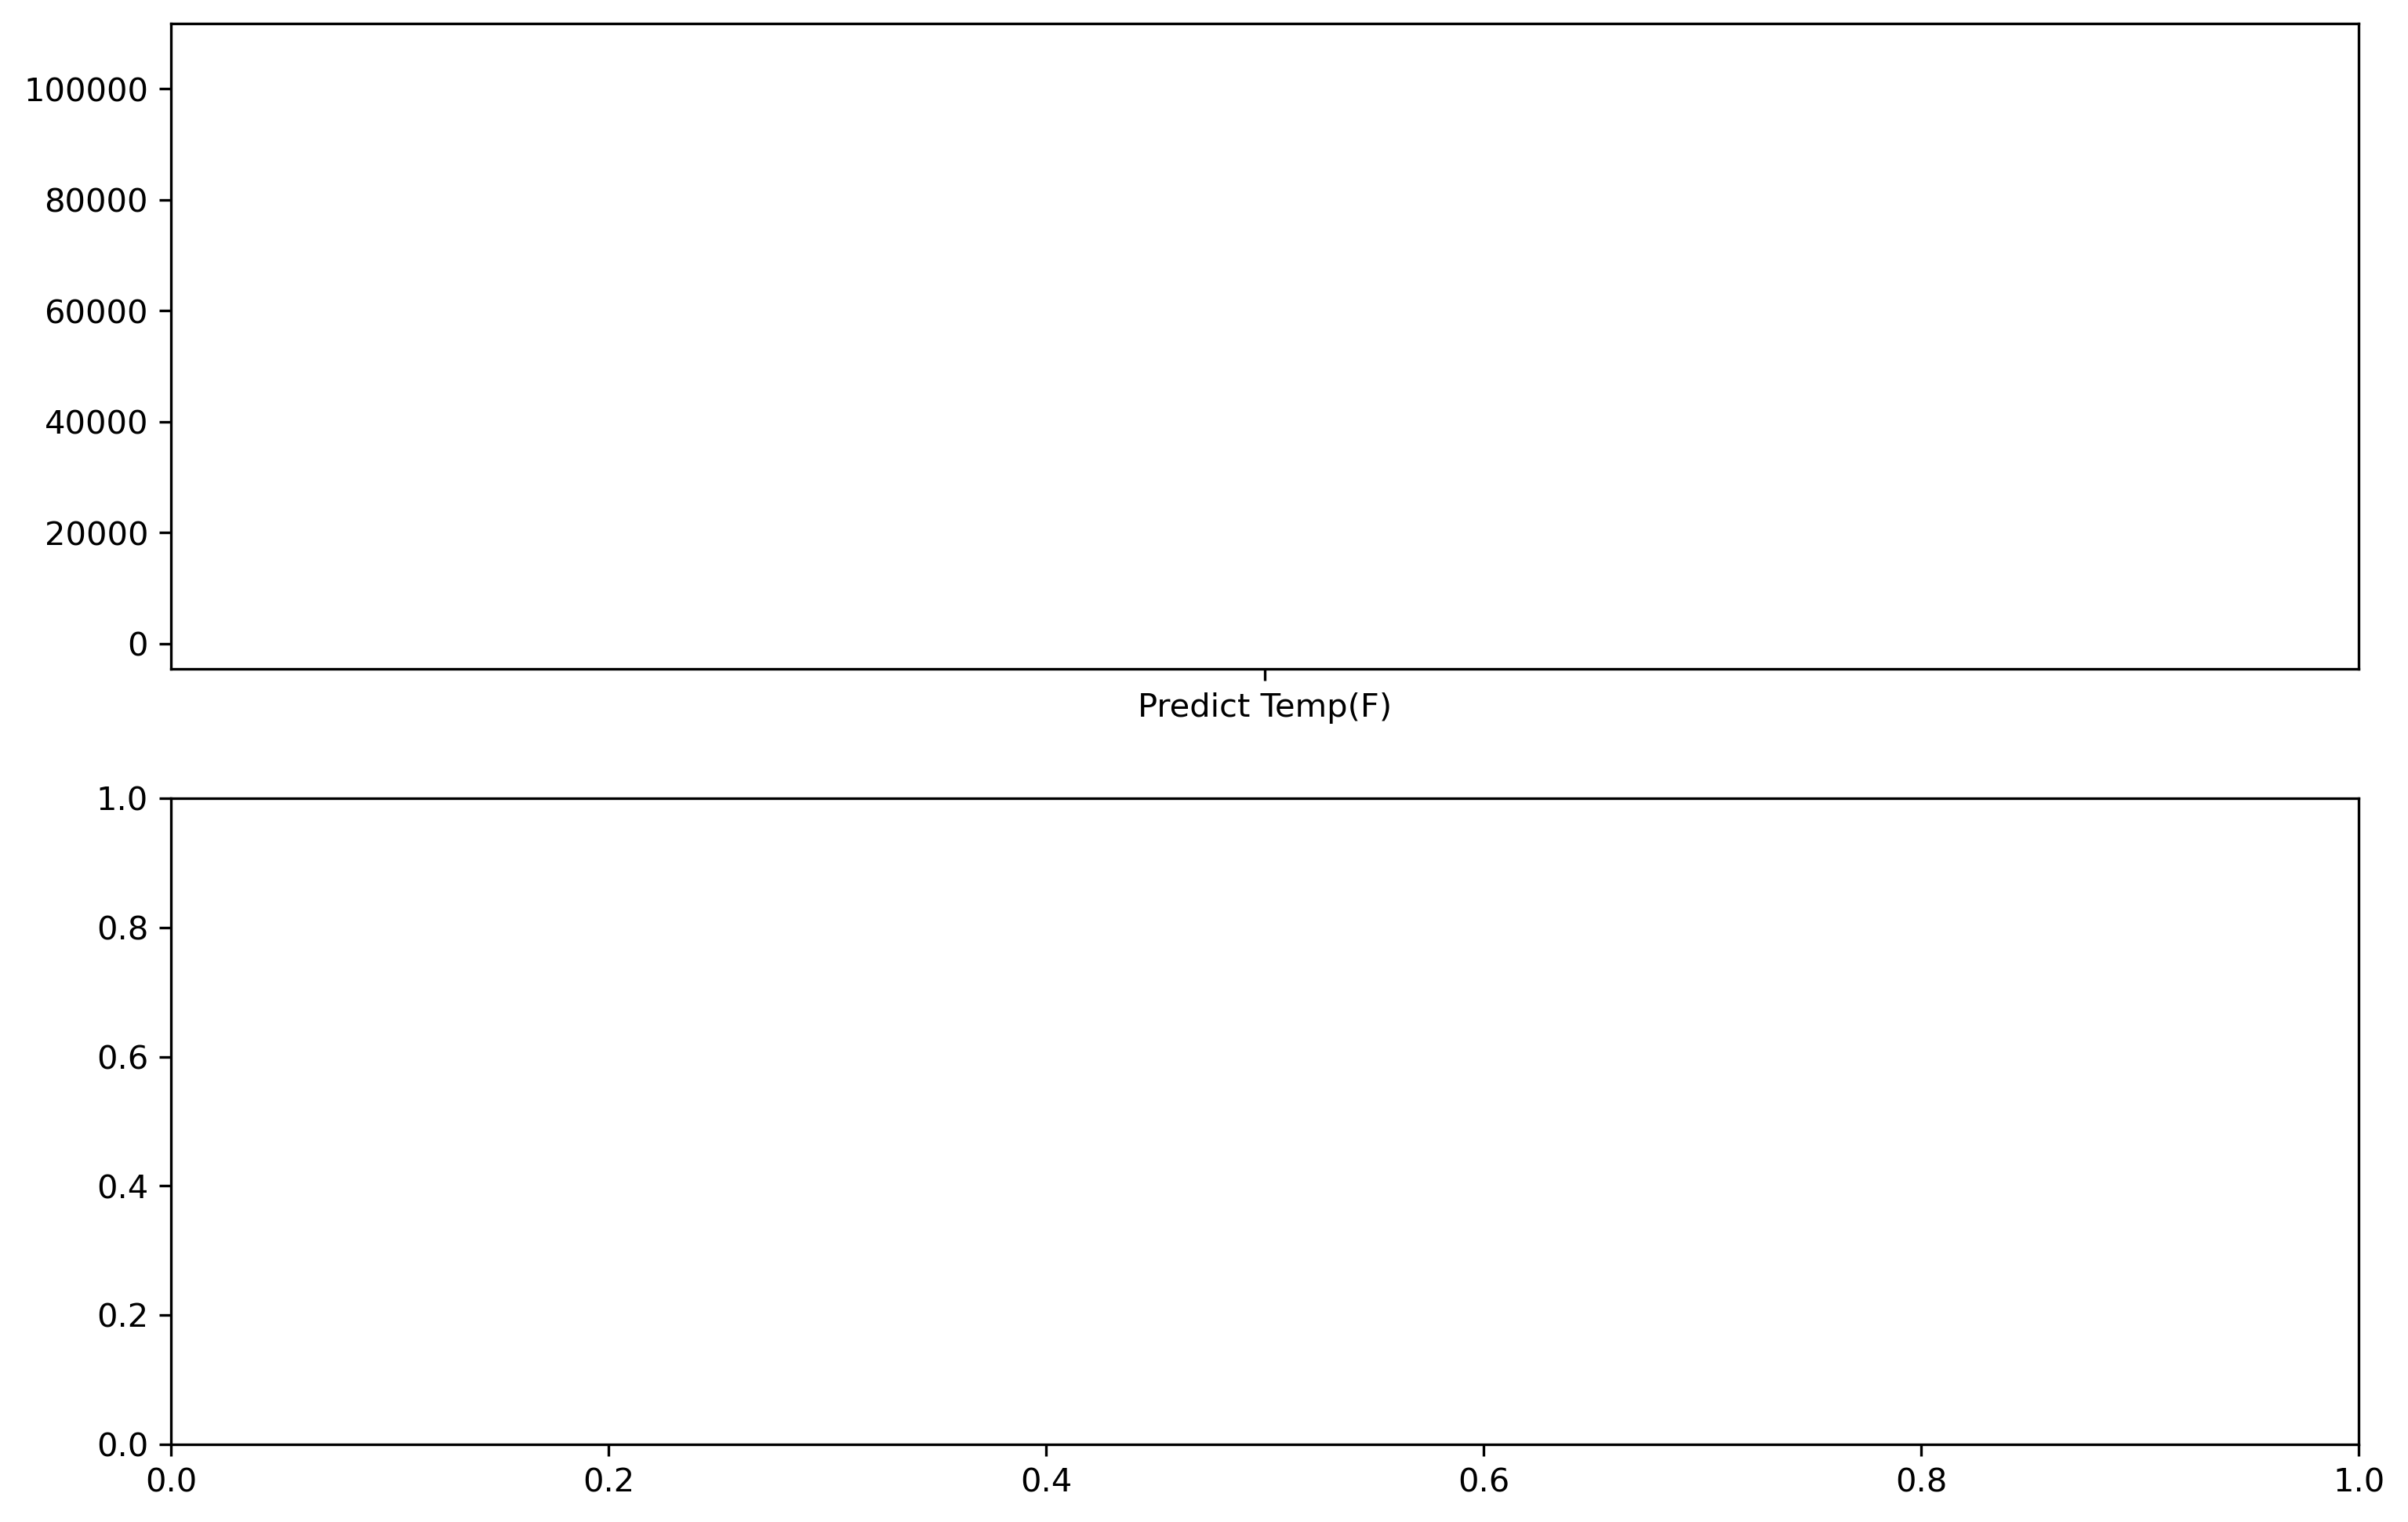

In [39]:
%matplotlib inline

plt.figure(dpi=300, figsize=(12,8))
plot4 = plt.subplot2grid((2,1),(0,0))
plot5 = plt.subplot2grid((2,1),(1,0))

plot4.scatter('Interior Temp (F)', 'Altitude (ft)', data=df, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot4.scatter('Predict Temp(F)', 'Altitude (ft)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.3, linewidth=0.3)
plot4.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot4.set_xlabel('Tempurature (F)', size='x-small')
plot4.set_ylabel('Altitude (ft)', size='x-small')
plot4.set_title('Temperature vs. Altitude', color='blue', size='small', pad=10.0, weight='bold')
plot4.grid(visible=True, which='both', linewidth=0.3)
plot4.set_xlim([-80,95])
plot4.set_ylim([-10000,110000])
plot4.legend(['Interior Temp', 'Predicted Temp', 'Exterior Temp'], fontsize='x-small', loc='lower left')

plot5.scatter('GPS Epoch', 'Interior Temp (F)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.4, linewidth=0.3)
plot5.scatter('GPS Epoch', 'Predict Temp(F)', data=df, marker='.', color='red', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot5.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot5.set_xlabel('Time (sec)', size='x-small')
plot5.set_ylabel('Payload Temp (F)', size='x-small')
plot5.set_title('Payload Temp (F)', color='blue', size='small', pad=10.0, weight='bold')
plot5.grid(visible=True, which='both', linewidth=0.3)
plot5.set_ylim([-80,95])
plot5.set_xlim([0,9000])
plot5.legend(['Interior Temp', 'Predicted Temp'], fontsize='x-small', loc='lower left')

plt.tight_layout(pad=1.5)
plt.show()

In [ ]:
df2.columns

In [ ]:
%matplotlib inline

plt.figure(dpi=175, figsize=(10,6))
plot1 = plt.subplot2grid((1,1),(0,0))

plot1.scatter('Predict Pressure', 'Altitude (ft)', marker='.', data=df2, color='red', alpha=0.4, linewidth=0.8)
plot1.scatter('I Pressure', 'Altitude (ft)', marker='.', data=df2, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_ylabel('Altitude (feet)', size='small')
plot1.set_title('Altitude vs. Pressure', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.legend(['Interior Pressure (BMP180)', 'Predicted Pressure'], fontsize='small', loc='upper left')
plot1.set_xlim([1200,-50])

plt.tight_layout(pad=5.0)
plt.show()

In [ ]:
df2.columns

In [ ]:
%matplotlib inline

plt.figure(dpi=800, figsize=(10,10))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('Altitude (ft)', 'HDOP (ft)', marker='.', data=df2, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Altitude (ft)', size='small')
plot1.set_ylabel('HDOP (ft)', size='small')
plot1.set_title('HDOP vs. Altitude', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)

plot2.scatter('Speed (mph)', 'HDOP (ft)', marker='.', data=df2, color='darkgreen', alpha=0.4, linewidth=0.8)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Speed (mph)', size='small')
plot2.set_ylabel('HDOP (ft)', size='small')
plot2.set_title('HDOP vs. Speed', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot2.grid(visible=True, which='both', linewidth=0.3)

plot3.scatter('Rate (fps)', 'HDOP (ft)', marker='.', data=df2, color='orange', alpha=0.5, linewidth=0.8)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Ascent/Descent Rate (fps)', size='small')
plot3.set_ylabel('HDOP (ft)', size='small')
plot3.set_title('HDOP vs. Rate', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot3.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [ ]:
df2.columns

In [ ]:
%matplotlib inline

plt.figure(dpi=200, figsize=(8,20))
plot1 = plt.subplot2grid((2,1),(0,0))

plot1.scatter('I Pressure', 'Interior Temp (C)', marker='.', data=df2, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_ylabel('Temperature (C)', size='small')
plot1.set_title('Interior Temp vs. Interior Pressure', color='blue', fontsize='small', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [ ]:
df2.columns

In [ ]:
df2.head(5)

In [ ]:
df2['Lat_DD'] = df2['Lat'].apply(convert_lat_gps_coord)

In [ ]:
df2['Lon_DD'] = df2['Lon'].apply(convert_lon_gps_coord)

In [ ]:
df2.tail(5)

In [ ]:
# Drop last row since it's invalid
# df2.drop(df2.tail(1).index,inplace=True)

In [ ]:
df2.tail(5)

In [ ]:
mid = int(len(df2['Lon_DD'])/2)

In [ ]:
scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

In [ ]:
fig = go.Figure(go.Scattermapbox(
    name = 'Flight Path',
    mode = "markers+lines",
    lon = df2['Lon_DD'],
    lat = df2['Lat_DD'],
    hoverinfo = 'lon+lat',
    hovertemplate =
    "Longitude: %{lon}<br>" +
    "Latitude: %{lat}<br>" + 
    "%{text}",
    text = 'Altitude: ' + df2['Altitude (ft)'].astype(str) + ' (ft)<br>Speed:' + df2['Speed (mph)'].astype(str) +  '<br>Int Temp: ' + df2['Interior Temp (C)'].astype(str) + '<br>Int Pressure: ' + df2['Interior Pressure'].astype(str),
    marker = dict(
        size = 7,
        opacity = 1.0,
        symbol = 'circle',    
        reversescale = False,
        autocolorscale = False,
        colorscale = scl,
        cmin = 0,
        color = df2['Altitude (ft)'], 
        cmax = df2['Altitude (ft)'].max(),
        colorbar_title="<b>High Altitude Balloon</b><br>April 21st 2023")))

In [ ]:
fig.update_layout(
    height = 750,
    width = 1500,
    margin ={'l':10,'t':50,'b':10,'r':10},
    mapbox = {
        'center': {'lon': df2['Lon_DD'].iloc[mid], 'lat': df2['Lat_DD'].iloc[mid]},
        'style': "stamen-terrain",
        'zoom': 9.5,
        })

fig.update_layout(
        title = '<b>High Altitude Balloon - Flight Path & Altitude</b>',
        geo_scope='usa',
        geo = dict(
            scope = 'north america',
            showland = True,
            landcolor = "rgb(212, 212, 212)",
            subunitcolor = "rgb(255, 255, 255)",
            countrycolor = "rgb(255, 255, 255)",
            showlakes = True,
            lakecolor = "rgb(255, 255, 255)",
            showsubunits = True,
            showcountries = True,
            resolution = 50,
            projection = dict(
                type = 'conic conformal',
                rotation_lon = -100
            ),
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.5,
                range= [ -140.0, -55.0 ],
                dtick = 5
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.5,
                range= [ 20.0, 60.0 ],
                dtick = 5
            )
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        ),
    )

fig.show()